# Continuous Control

---

In this notebook, you will see a solution for Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## Importing packages

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

## Defining the implementation, using DDPG

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class Actor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=1e-4):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        self.tanh = nn.Tanh()

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, learning_rate=1e-4):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim + action_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state, action):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(torch.cat([x, action], dim=1)))
        x = self.fc3(x)
        return x


In [3]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)


class DDPG:
    def __init__(self, state_dim, action_dim, hidden_dim, buffer_size, batch_size, actor_lr, critic_lr, tau, gamma):
        self.actor = Actor(state_dim, hidden_dim, action_dim, actor_lr)
        self.actor_target = Actor(state_dim, hidden_dim, action_dim, actor_lr)
        self.critic = Critic(state_dim, action_dim, hidden_dim, critic_lr)
        self.critic_target = Critic(state_dim, action_dim, hidden_dim, critic_lr)

        self.memory = ReplayBuffer(buffer_size, batch_size)
        self.batch_size = batch_size
        self.tau = tau
        self.gamma = gamma

        self._update_target_networks(tau=1)  # initialize target networks

    def act(self, state, noise=0.0):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        return np.clip(action + noise, -1, 1)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample()

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        # Update Critic
        self.critic.optimizer.zero_grad()

        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_q_values = self.critic_target(next_states, next_actions)
            target_q_values = rewards + (1 - dones) * self.gamma * target_q_values

        current_q_values = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_q_values, target_q_values)

        critic_loss.backward()
        self.critic.optimizer.step()

        # Update Actor
        self.actor.optimizer.zero_grad()

        actor_loss = -self.critic(states, self.actor(states)).mean()
        actor_loss.backward()
        self.actor.optimizer.step()

        # Update target networks
        self._update_target_networks()

    def _update_target_networks(self, tau=None):
        if tau is None:
            tau = self.tau

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


In [5]:
%%time

def train_ddpg(env, agent, episodes, max_steps, num_agents, noise_scale=0.1, noise_decay=0.99):
    scores_window = deque(maxlen=100)
    scores = []

    for episode in range(1, episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent_scores = np.zeros(num_agents)

        for step in range(max_steps):
            actions = agent.act(states, noise_scale)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            for i in range(num_agents):
                agent.store_transition(states[i], actions[i], rewards[i], next_states[i], dones[i])
            agent.learn()

            states = next_states
            agent_scores += rewards
            noise_scale *= noise_decay

            if np.any(dones):
                break

        avg_score = np.mean(agent_scores)
        scores_window.append(avg_score)
        scores.append(avg_score)

        if episode % 10 == 0:
            print(f"Episode: {episode}, Score: {avg_score:.2f}, Avg Score: {np.mean(scores_window):.2f}")

#         if np.mean(scores_window) >= 30.0:
#             print(f"Environment solved in {episode} episodes!")
            
#             break

        # Saving trained Networks
        torch.save(agent.actor.state_dict(), "actor_final.pth")
        torch.save(agent.critic.state_dict(), "critic_final.pth")

    return scores

if __name__ == "__main__":
    env = UnityEnvironment(file_name='Reacher_20.app')
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    state_dim = 33
    action_dim = brain.vector_action_space_size

    num_agents = 20
    
    # Hyperparameter suggestions
    hidden_dim = 400
    batch_size = 256
    actor_lr = 5e-4
    critic_lr = 1e-3
    tau = 5e-3
    gamma = 0.995
    noise_scale = 0.5
    noise_decay = 0.998

    agent = DDPG(state_dim, action_dim, hidden_dim=hidden_dim, buffer_size=200000, batch_size=batch_size,
                 actor_lr=actor_lr, critic_lr=critic_lr, tau=tau, gamma=gamma)

    episodes = 200
    max_steps = 1000

    scores = train_ddpg(env, agent, episodes, max_steps, num_agents, noise_scale=0.2, noise_decay=0.995)


Mono path[0] = '/Users/cassimiro/code/projects/rl-robot-movement/p2_continuous-control/Reacher_20.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/cassimiro/code/projects/rl-robot-movement/p2_continuous-control/Reacher_20.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
/var/folders/nn/1yjvcwm12w78v3fpkk6_2_r00000gn/T/ipykernel_72738/569685294.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  states = t

Episode: 10, Score: 0.21, Avg Score: 0.74
Episode: 20, Score: 7.10, Avg Score: 2.16
Episode: 30, Score: 20.44, Avg Score: 6.53
Episode: 40, Score: 27.76, Avg Score: 10.97
Episode: 50, Score: 35.70, Avg Score: 14.88
Episode: 60, Score: 37.95, Avg Score: 18.47
Episode: 70, Score: 35.13, Avg Score: 21.00
Episode: 80, Score: 38.01, Avg Score: 22.96
Episode: 90, Score: 37.48, Avg Score: 24.54
Episode: 100, Score: 34.65, Avg Score: 25.76
Episode: 110, Score: 36.98, Avg Score: 29.32
Episode: 120, Score: 33.05, Avg Score: 32.55
Episode: 130, Score: 36.27, Avg Score: 34.57
Episode: 140, Score: 35.46, Avg Score: 35.68
Episode: 150, Score: 35.96, Avg Score: 36.21
Episode: 160, Score: 34.14, Avg Score: 36.05
Episode: 170, Score: 33.38, Avg Score: 36.01
Episode: 180, Score: 35.22, Avg Score: 35.88
Episode: 190, Score: 36.10, Avg Score: 35.62
Episode: 200, Score: 35.58, Avg Score: 35.40
CPU times: user 31min 22s, sys: 8min 35s, total: 39min 57s
Wall time: 37min 17s


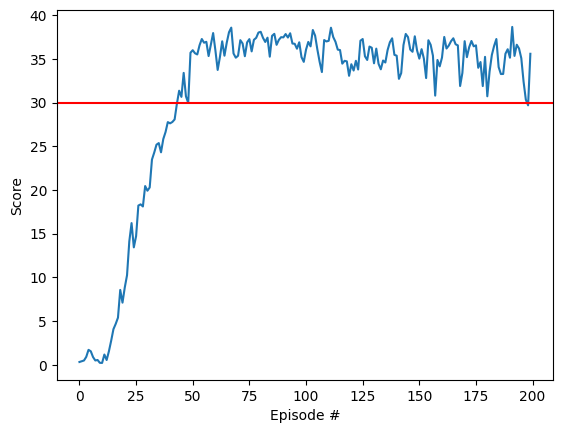

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.axhline(30,color='r')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('training_best.png')
plt.show()

In [10]:
env.close()